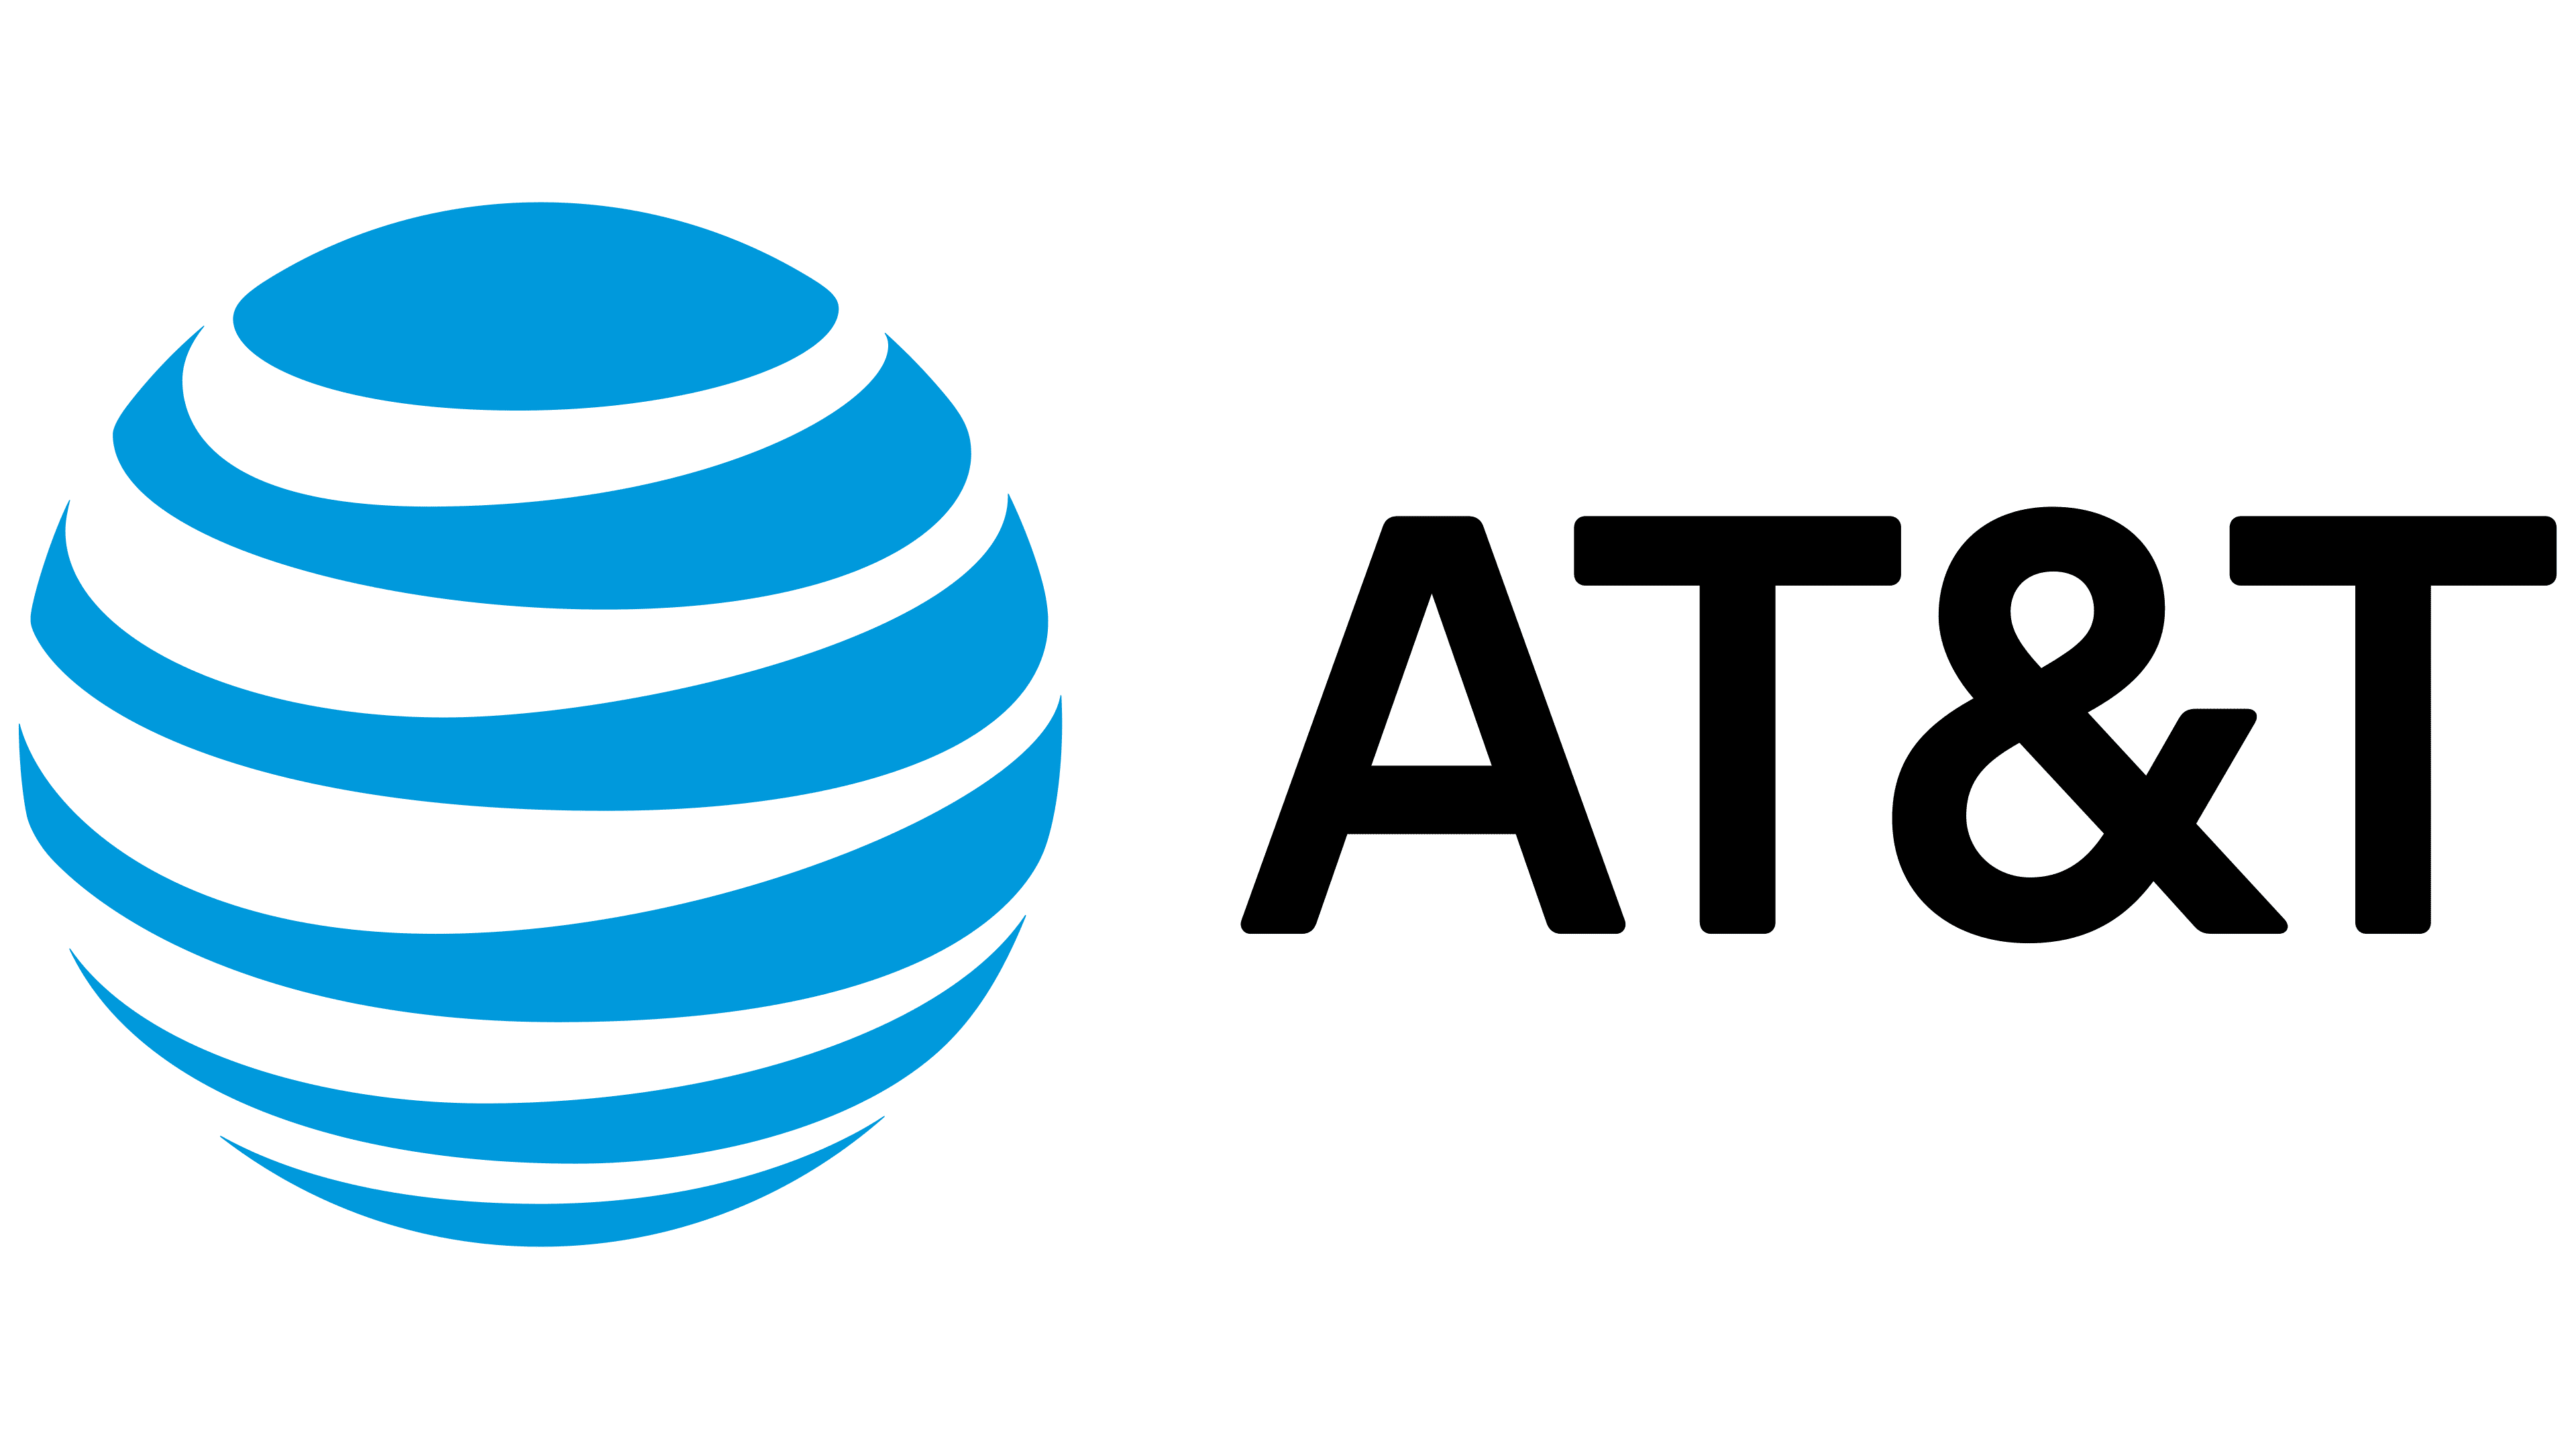

In [37]:
# prompt: add image

from IPython.display import Image
Image('/content/drive/MyDrive/Projet 9 - Deep Learning/img/ATT-Logo.png', width=400)

For this Block 4 project, I'll present a problem faced by AT&T users due to constant exposure to spam.

AT&T is looking for an automated way to detect spam to protect its users.

The goal is to create a spam detector capable of automatically flagging spam as soon as it arrives, based solely on the content of the text message.

**Project Overview**

1- Load needed librairies

2- Load dataset and get some informations about

3- Preprocessing the text message dataset
  - For LSTM model
  - For BERT

4- Create a deep learning model
  - Train model
  - Evaluate model

5- Use a transfer learning with Bert Model
  - Train model
  - Evaluate model

6- Visualizations

# Import useful librairies

In [38]:
import transformers
print(transformers.__version__)


4.52.4


In [39]:
# Data manipulation
import pandas as pd
import numpy as np

# Data cleaning
import re
import string

# Preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep learning
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader, Dataset


# Models
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertTokenizer
from transformers import DistilBertForSequenceClassification
from torch.optim import AdamW

# Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, recall_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration du device (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Utilisation du device: {device}")

Utilisation du device: cpu


# 📋 Load and explore data

In [40]:
def load_and_explore_data(filepath):
  """
  Load and explore data
  """
  # Load data
  data = pd.read_csv(filepath, encoding='latin-1')

  # Drop unnecessary columns
  data = data.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
  data = data.rename(columns={"v1" : "label", "v2" : "text"})

  # Show basic informations
  print("-----Data exploration-----")
  print(f"Data shape : {data.shape}")
  print()
  print(f"Columns : {data.columns}")
  print()
  print(f"Missign values : {data.isna().sum()}")
  print()

  # Classes distribution
  print("\n-----Classes distribution-----")
  print(data['label'].value_counts())
  print()

  # Distribution visualization
  plt.figure(figsize=(8, 5))
  data.groupby('label').size().plot(kind="bar", color=["#1E4454", "#93D7C5"])
  plt.title("Classes distribution (Ham vs Spam)")
  plt.xlabel("Classes")
  plt.ylabel("Number of messages")
  plt.show()

  return data

# ⚙️ Preprocessing

In [41]:
class TextPreprocessor:
  """
  Class to preprocess text data
  """

  def __init__(self):
    # Personnalized stopwords
    self.stopwords = [
            "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are",
            "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but",
            "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from",
            "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here",
            "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll",
            "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me",
            "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
            "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's",
            "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them",
            "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're",
            "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was",
            "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where",
            "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you",
            "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"
        ]

  def clean_text(self, text):
    """
      Cleans up text by removing unwanted elements
    """
    if pd.isna(text):
      return ""

    text = text.lower()
    """
      Make text lowercase, remove text in square brackets,remove links,remove punctuation
      and remove words containing numbers
    """
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)      # links
    text = re.sub(r"\S+@\S+", '', text)                      # emails
    text = re.sub(r"\d+", '', text)                          # numbers
    text = re.sub(r"[^\w\s]", '', text)                      # punctuation
    text = re.sub(r"\s+", ' ', text).strip()                 # spaces
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)               # coooool -> coolsub

    # Delete stopwords
    tokens = text.split()
    tokens = [word for word in tokens if word not in self.stopwords and len(word) > 2]
    text = ' '.join(tokens)

    # Return cleaned text
    return text

  def prepare_data(self, data):
    """
      Prepares data for training
    """

    # Apply cleaning data
    data["clean_text"] = data["text"].apply(self.clean_text)

    # Label encoding (spam=1, ham=0)
    data["spam"] = data["label"].apply(lambda x: 1 if x =="spam" else 0)

    print("-----Preprocessing completed-----")
    print("Examples of cleaned text:")
    for i in range(3) :
      print(f"\n Original text : {data['text'].iloc[i][:100]} ...")
      print(f"Cleaned text : {data['clean_text'].iloc[i][:100]} ...")

    return data


# 「 ✦ LSTM ✦ 」

In [42]:
class SpamLSTM(nn.Module):
  """
    LSTM model for spam detection
  """
  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.3):
    super(SpamLSTM, self).__init__()

    # Embedding layer to convert words into vectors
    self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

    # Bidirectional LSTM layer to capture context
    self.lstm = nn.LSTM(
        embedding_dim,
        hidden_dim,
        num_layers = num_layers,
        batch_first=True,
        dropout = dropout if num_layers > 1 else 0,
        bidirectional = True
        )

    # Fully connected layers with dropout for regularization
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, 1)

  def forward(self, x):
    # Embedding
    embedded = self.embedding(x)

    # Passage through LSTM
    lstm_out, (hidden, _) = self.lstm(embedded)

    # Using that last LSTM outpup
    # For a bidirectional LSTM, we concatenate the final hidden states
    if self.lstm.bidirectional :
      # Concatenation of forward and backward directions
      hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
    else:
      hidden = hidden[-1]

    # Passing through the fully connected layers
    x = self.dropout(hidden)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    output = torch.sigmoid(self.fc2(x))

    return output.squeeze()

# 「 ✦ BERT ✦ 」

In [43]:
class SpamDataset(Dataset):
  """
    Custom Dataset for BERT
  """
  def __init__(self, texts, labels, tokenizer, max_length=128):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts.iloc[idx]) if hasattr(self.texts, 'iloc') else str(self.texts[idx])
    label = self.labels.iloc[idx] if hasattr(self.labels, 'iloc') else self.labels[idx]

    # Tokenization with BERT
    encoding = self.tokenizer(
        text,
        truncation=True,
        padding = 'max_length',
        max_length = self.max_length,
        return_tensors='pt'
    )

    return {
        'input_ids': encoding['input_ids'].flatten(),
        'attention_mask': encoding['attention_mask'].flatten(),
        'labels': torch.tensor(label, dtype=torch.long)
    }

# 🤸 Training models

In [44]:
# @title LSTM
class LSTMTrainer:
  """
    Trainer class for LSTM model
  """

  def __init__(self, vocab_size=5000, embedding_dim=100, hidden_dim=128, max_length=100) :
    self.vocab_size = vocab_size
    self.embedding_dim = embedding_dim
    self.hidden_dim = hidden_dim
    self.max_length = max_length
    self.tokenizer = None
    self.model = None
    self.train_losses = []
    self.val_losses = []
    self.val_accuracies = []

  def preprare_data(self, X_train, X_test, y_train, y_test):
    """
      Prepares data for LSTM training
    """
    # Tokenization with keras
    self.tokenizer = Tokenizer(num_words=self.vocab_size, oov_token="<OOV>")
    self.tokenizer.fit_on_texts(X_train)
    word_index = self.tokenizer.word_index

    # Conversion to sequences
    train_sequences = self.tokenizer.texts_to_sequences(X_train)
    test_sequences = self.tokenizer.texts_to_sequences(X_test)

    # Calculate the maximum length
    max_len = max([len(seq) for seq in train_sequences])
    self.max_length = min(max_len, self.max_length)

    # Padding
    X_train = pad_sequences(train_sequences, maxlen = self.max_length, padding='post')
    X_test = pad_sequences(test_sequences, maxlen = self.max_length, padding='post')

    # Concert to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.long)
    y_train = torch.tensor(y_train.values, dtype=torch.float)
    y_test = torch.tensor(y_test.values, dtype=torch.float)

    print()
    print(f"Vocabulary size: {self.vocab_size}")
    print(f"Maximum sequence length: {self.max_length}")
    print(f"Form of training data: {X_train.shape}")
    print()

    return X_train, X_test, y_train, y_test

  def train(self, X_train, X_test, y_train, y_test, epochs=5, batch_size=32, lr=1e-3) :
      """
        Trains the LSTM model
      """
      # Create the model
      self.model = SpamLSTM(
          vocab_size=self.vocab_size,
          embedding_dim=self.embedding_dim,
          hidden_dim = self.hidden_dim
        ).to(device)

      # Optimizer and loss function
      optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
      criterion = nn.BCELoss()

      # Dataloaders
      train_dataset = TensorDataset(X_train, y_train)
      test_dataset = TensorDataset(X_test, y_test)
      train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
      test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

      # Training loop
      for epoch in range(epochs):
        self.model.train()
        train_loss =0.0

        for batch_x, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)

          optimizer.zero_grad()
          outputs = self.model(batch_x)
          loss = criterion(outputs, batch_y)
          loss.backward()
          optimizer.step()

      # Validation phase
      self.model.eval()
      val_loss = 0.0
      correct = 0
      total = 0

      with torch.no_grad():
        for batch_x, batch_y in test_loader:
          batch_x, batch_y = batch_x.to(device), batch_y.to(device)
          outputs = self.model(batch_x)
          loss = criterion(outputs, batch_y)
          val_loss += loss.item()

          predictions = (outputs > 0.5).float()
          correct += (predictions == batch_y).sum().item()
          total += batch_y.size(0)

      # Saving metrics
      train_loss /= len(train_loader)
      val_loss /= len(test_loader)
      val_accuracy = correct / total

      self.train_losses.append(train_loss)
      self.val_losses.append(val_loss)
      self.val_accuracies.append(val_accuracy)

      print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val Accuracy: {val_accuracy:.4f}")
      print()

  def evaluate(self, X_test, y_test):
    """
      Evaluates the LSTM model
    """
    self.model.eval()
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
      for batch_x, batch_y in test_loader :
        batch_x = batch_x.to(device)
        outputs = self.model(batch_x)
        prediction = (outputs > 0.5).int()

        all_predictions.extend(prediction.cpu().numpy())
        all_labels.extend(batch_y.numpy())

    return all_predictions, all_labels

In [45]:
# @title BERT
class BERTTrainer :
  """
    Class for train BERT model
  """
  def __init__(self, model_name='distilbert-base-uncased', max_length=128):
    self.model_name = model_name
    self.max_length = max_length
    self.tokenizer = None
    self.model = None
    self.train_losses = []

  def prepare_data(self, X_train, X_test, y_train, y_test):
    """
      Prepares data for BERT training
    """
    print("=== BERT DATA PREPARATION ===")

    # Using DistilBERT (faster than full BERT)
    self.tokenizer = DistilBertTokenizer.from_pretrained(self.model_name)

    # Creating Datasets
    train_dataset = SpamDataset(X_train, y_train, self.tokenizer, self.max_length)
    test_dataset = SpamDataset(X_test, y_test, self.tokenizer, self.max_length)

    print()
    print(f"Maximum sequence length: {self.max_length}")
    print(f"Training dataset size: {len(train_dataset)}")
    print()

    return train_dataset, test_dataset

  def train(self, train_dataset, test_dataset, epochs=3, batch_size=16, lr=2e-5):
    """
      Trains the BERT model
    """
    print("=== BERT TRAINING ===")

    # Using DistilBERT for classification
    self.model = DistilBertForSequenceClassification.from_pretrained(
        self.model_name,
        num_labels=2).to(device)

    # DataLoaders with reduced batch_size to save memory
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Specialized optimizer for transformers
    optimizer = AdamW(self.model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
      self.model.train()
      total_loss = 0

      progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
      for batch in progress_bar :
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        progress_bar.set_postfix({'loss': loss.item()})

      avg_loss = total_loss / len(train_loader)
      self.train_losses.append(avg_loss)

      print(f"Epoch {epoch+1} - Average Loss : {avg_loss:.4f}")
    print()

  def evaluate(self, test_dataset):
    """
      Evaluate the BERT model
    """
    self.model.eval()
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Évaluation"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_predictions, all_labels

# 📈 Visualization

In [49]:
def visualize_results(lstm_trainer, results):
    """
      Creates visualizations of the results
    """

    # Confusion matrix for LSTM
    if 'LSTM' in results:
      plt.figure(figsize=(8, 6))
      cm_lstm = confusion_matrix(results['LSTM']['labels'], results['LSTM']['predictions'])
      sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues')
      plt.title('Confusion Matrix - LSTM')
      plt.xlabel('Predictions')
      plt.ylabel('True values')
      plt.show()

    # Metrics comparison
    if len(results) > 1:
      plt.figure(figsize=(10, 6))
      models = list(results.keys())
      metrics = ['accuracy', 'precision', 'recall', 'f1_score']

      x = np.arange(len(metrics))
      width = 0.35

      for i, model in enumerate(models):
          values = [results[model][metric] for metric in metrics]
          plt.bar(x + i*width, values, width, label=model)

      plt.title('Comparison of metrics')
      plt.xlabel('Metrics')
      plt.ylabel('Score')
      plt.xticks(x + width/2, metrics)
      plt.legend()
      plt.show()

def print_final_summary(results):
    """
      Shows the final summary of results
    """
    print("\n" + "="*60)
    print("FINAL SUMMARY - MODEL COMPARISON")
    print("="*60)

    if not results:
        print("No results available.")
        return

    # Find the best model
    best_model = max(results.keys(), key=lambda x: results[x]['accuracy'])
    best_accuracy = results[best_model]['accuracy']

    print(f"\nBest model : {best_model}")
    print(f"Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
    print(f"Precision (classe spam): {results[best_model]['precision']:.4f}")
    print(f"Recall (classe spam): {results[best_model]['recall']:.4f}")
    print(f"F1-Score (classe spam): {results[best_model]['f1_score']:.4f}")

    print(f"\n DETAILED COMPARISON :")
    print("-" * 80)
    print(f"{'Model':<10} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
    print("-" * 80)

    for model_name, metrics in results.items():
        print(f"{model_name:<10} {metrics['accuracy']:<10.4f} {metrics['precision']:<10.4f} "
              f"{metrics['recall']:<10.4f} {metrics['f1_score']:<10.4f}")


# ✅ Main execution function


In [50]:
def main():
  """
    Main function that executes the entire project
  """

  # Load and explore data
  print("Loading data ...")
  print()
  filepath ="/content/drive/MyDrive/Projet 9 - Deep Learning/src/spam.csv"
  data = load_and_explore_data(filepath)
  print()

  # Preprocesing
  preprocessor = TextPreprocessor()
  data = preprocessor.prepare_data(data)

  # Train test split
  X = data['clean_text']
  y = data['spam']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

  print()
  print(f"Train data size : {len(X_train)}")
  print(f"Test data size : {len(X_test)}")

  # Storing results
  results = {}

  # LSTM model training
  print("\n" + "="*50)
  print("LSTM model training")
  print("="*50)

  lstm_trainer = LSTMTrainer()
  X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = lstm_trainer.preprare_data(X_train, X_test, y_train, y_test)

  lstm_trainer.train(X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm, epochs=5)
  lstm_preds, lstm_labels = lstm_trainer.evaluate(X_test_lstm, y_test_lstm)

  # LSTM metrics
  lstm_accuracy = accuracy_score(lstm_labels, lstm_preds)
  lstm_report = classification_report(lstm_labels, lstm_preds, output_dict=True)

  results['LSTM'] = {
        'accuracy': lstm_accuracy,
        'precision': lstm_report['1.0']['precision'],
        'recall': lstm_report['1.0']['recall'],
        'f1_score': lstm_report['1.0']['f1-score'],
        'predictions': lstm_preds,
        'labels': lstm_labels
    }

  print(f"\n=== LSTM RESULTS ===")
  print(f"Accuracy : {lstm_accuracy:.4f}")
  print(classification_report(lstm_labels, lstm_preds))
  print()

  # BERT model training
  print("\n" + "="*50)
  print("TRAINING THE BERT MODEL")
  print("="*50)


  bert_trainer = BERTTrainer()
  train_dataset, test_dataset = bert_trainer.prepare_data(
      X_train, X_test, y_train, y_test
  )

  bert_trainer.train(train_dataset, test_dataset, epochs=2)
  bert_preds, bert_labels = bert_trainer.evaluate(test_dataset)

  # BERT Metrics
  bert_accuracy = accuracy_score(bert_labels, bert_preds)
  bert_report = classification_report(bert_labels, bert_preds, output_dict=True)

  results['BERT'] = {
      'accuracy': bert_accuracy,
      'precision': bert_report['1']['precision'],
      'recall': bert_report['1']['recall'],
      'f1_score': bert_report['1']['f1-score'],
      'predictions': bert_preds,
      'labels': bert_labels
  }

  print(f"\n=== BERT RESULTS ===")
  print(f"Accuracy : {bert_accuracy:.4f}")
  print(classification_report(bert_labels, bert_preds))

  # Save models
  torch.save(lstm_trainer.model.state_dict(), "/content/drive/MyDrive/Projet 9 - Deep Learning/src/06062025/lstm_model.pth")
  torch.save(bert_trainer.model.state_dict(), "/content/drive/MyDrive/Projet 9 - Deep Learning/src/06062025/bert_model.pth")
  print("Models saved to /content/drive/MyDrive/Projet 9 - Deep Learning/src/06062025")

  # Visualizations and comparison
  visualize_results(lstm_trainer, results)

  # Final summary
  print_final_summary(results)


# ☝ Call main


Loading data ...

-----Data exploration-----
Data shape : (5572, 2)

Columns : Index(['label', 'text'], dtype='object')

Missign values : label    0
text     0
dtype: int64


-----Classes distribution-----
label
ham     4825
spam     747
Name: count, dtype: int64



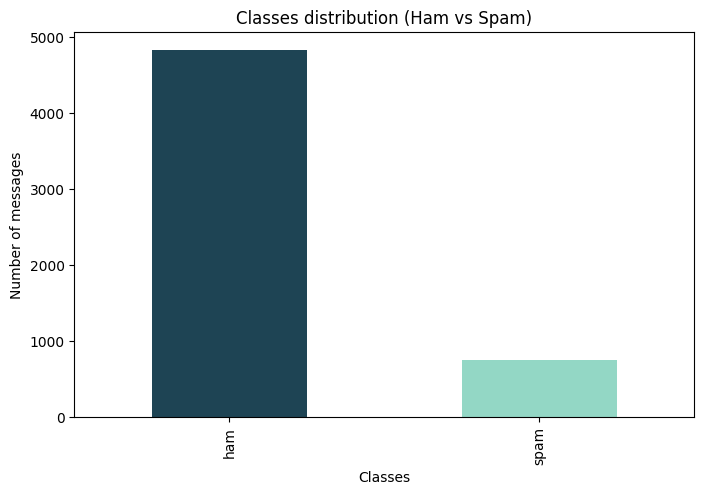


-----Preprocessing completed-----
Examples of cleaned text:

 Original text : Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got a ...
Cleaned text : jurong point crazy available bugis great world buffet cine got amore wat ...

 Original text : Ok lar... Joking wif u oni... ...
Cleaned text : lar joking wif oni ...

 Original text : Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entr ...
Cleaned text : free entry wkly comp win cup final tkts may text receive entry questionstd txt ratetcs apply overs ...

Train data size : 4457
Test data size : 1115

LSTM model training

Vocabulary size: 5000
Maximum sequence length: 86
Form of training data: torch.Size([4457, 86])



Epoch 5/5: 100%|██████████| 140/140 [00:16<00:00,  8.49it/s]


Epoch 5/5 - Train Loss: 0.0000 - Val Loss: 0.0888 - Val Accuracy: 0.9821


=== LSTM RESULTS ===
Accuracy : 0.9821
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       966
         1.0       0.98      0.89      0.93       149

    accuracy                           0.98      1115
   macro avg       0.98      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



TRAINING THE BERT MODEL
=== BERT DATA PREPARATION ===

Maximum sequence length: 128
Training dataset size: 4457

=== BERT TRAINING ===


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Epoch 1/2: 100%|██████████| 279/279 [44:24<00:00,  9.55s/it, loss=0.00568]


Epoch 1 - Average Loss : 0.1239


Epoch 2/2: 100%|██████████| 279/279 [43:58<00:00,  9.46s/it, loss=0.0076]


Epoch 2 - Average Loss : 0.0451



Évaluation: 100%|██████████| 70/70 [03:21<00:00,  2.87s/it]



=== BERT RESULTS ===
Accuracy : 0.9785
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       966
           1       0.90      0.95      0.92       149

    accuracy                           0.98      1115
   macro avg       0.94      0.96      0.95      1115
weighted avg       0.98      0.98      0.98      1115

Models saved to /content/drive/MyDrive/Projet 9 - Deep Learning/src/06062025


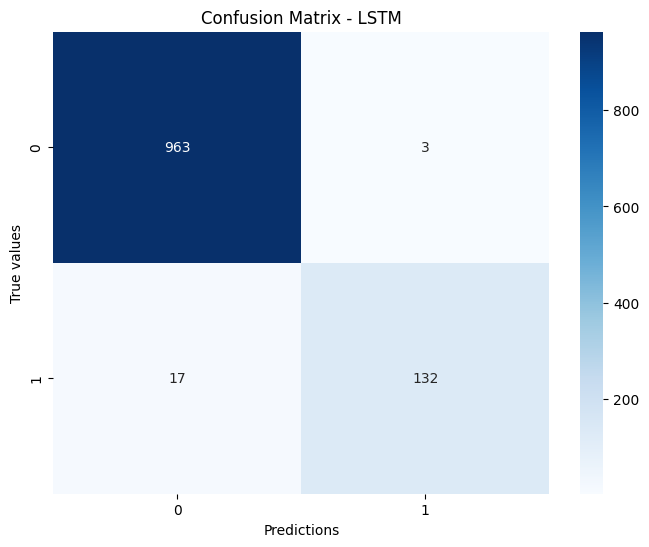

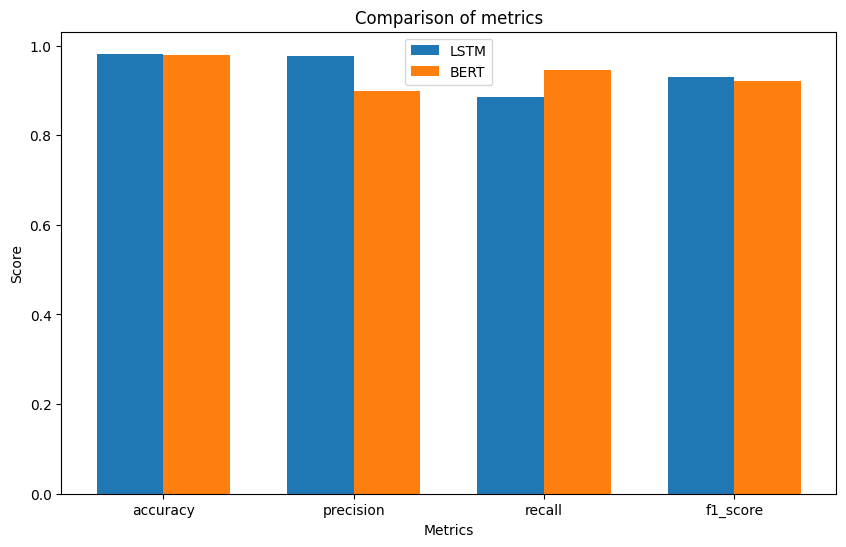


FINAL SUMMARY - MODEL COMPARISON

Best model : LSTM
Accuracy: 0.9821 (98.21%)
Precision (classe spam): 0.9778
Recall (classe spam): 0.8859
F1-Score (classe spam): 0.9296

 DETAILED COMPARISON :
--------------------------------------------------------------------------------
Model      Accuracy   Precision  Recall     F1-Score  
--------------------------------------------------------------------------------
LSTM       0.9821     0.9778     0.8859     0.9296    
BERT       0.9785     0.8981     0.9463     0.9216    


In [51]:
if __name__ == "__main__":
  main()